## HW11 数据分析及贝叶斯模型分类器
指导教师：胡俊峰

负责助教：苏亚鲁，李浩然

注意：仅需要提交.ipynb文件，请**不要**将下发压缩包中的其他文件一并交上。

截止日期：4月12日24点

### 第一部分：基础练习:用户观影数据分析（3分）

#### 1.1 用户偏好分析（3分）
    仿照课件中对pop_junk_movie的用户分析，分析pop_golden_movie的用户偏好情况，绘制图像并找到其中的非偏好人群的前3名。
    注：用户偏好通过根据用户数据中occ_desc项划分的不同用户群体的平均观影频率来反映，非偏好人群即平均观影频率较低的人群。

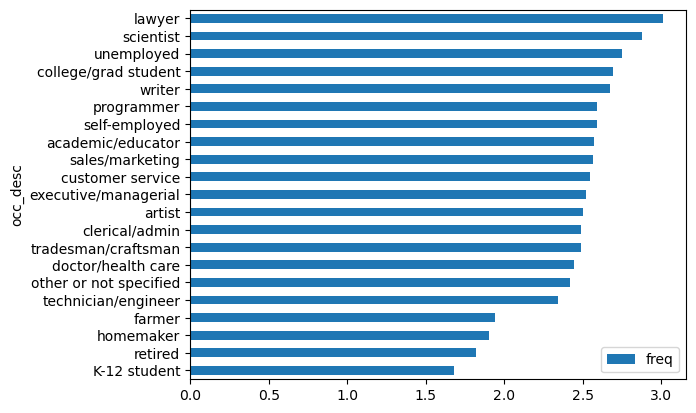

,movie_id,user_id,freq
occ_desc,,,
K-12 student,327,195,1.676923
retired,258,142,1.816901
homemaker,175,92,1.902174


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Reading ratings file
ratings = pd.read_csv('data/ratings2.csv',  encoding='latin-1', usecols=['user_id', 'movie_id', 'rating', 'timestamp'])

# Reading users file
users = pd.read_csv('data/users.csv', encoding='latin-1', usecols=['user_id', 'gender', 'zipcode', 'age_desc', 'occ_desc'])

# Reading movies file
movies = pd.read_csv('data/movies.csv',  encoding='latin-1', usecols=['movie_id', 'title', 'genres'])

ratings_movie_statis = ratings.groupby('movie_id').agg({'rating':'mean','user_id':'count'})
ratings_movie_statis.rename(columns={'rating':'rating_average','user_id':'user_count'}, inplace = True)

pop_golden_moives = ratings_movie_statis[(ratings_movie_statis['rating_average'] > 4.45) & (ratings_movie_statis['user_count']>900)]

golden_gener_distri =  pop_golden_moives.merge(movies, left_on = 'movie_id', right_on ='movie_id')
golden_gener_distri 

golden_moive_users = ratings.merge(pop_golden_moives, left_on ='movie_id', right_on = 'movie_id', how = 'inner')
golden_moive_users

golden_moive_users_distri = golden_moive_users.merge(users, left_on ='user_id', right_on = 'user_id', how = 'left')
golden_moive_users_distri

show_distri = golden_moive_users_distri.groupby('occ_desc').agg({'movie_id':'count'})
user_occ_distri = users.groupby('occ_desc').agg({'user_id':'count'})

show_distri_freq = show_distri.merge(user_occ_distri, left_on ='occ_desc', right_on = 'occ_desc', how = 'inner')
show_distri_freq['freq'] = show_distri_freq['movie_id'] / show_distri_freq['user_id']
show_distri_freq.sort_values('freq',inplace = True)
show_distri_freq

show_distri_freq.plot.barh( y ='freq')
plt.show()
display(show_distri_freq[0:3])





#### 1.2 对特定类型电影进行用户偏好分析（附加题，不占分）
    按照电影的类型进行拆分，并分析Comedy和Action两种类型电影的用户偏好。

### 第二部分：进阶练习（7分）
    使用贝叶斯模型来为用户推荐电影。

In [4]:
import numpy as np
import pandas as pd

# 读取 ratings 文件
ratings = pd.read_csv('data/ratings2.csv',  encoding='latin-1', usecols=['user_id', 'movie_id', 'rating', 'timestamp'])
# 使用全部数据填写数据矩阵，避免造成用户/电影的缺省
user_movie_matrix = ratings.pivot_table('rating', index='user_id', columns='movie_id', aggfunc='mean').fillna(0)
user_movie_matrix.shape

(6040, 3706)

In [5]:
import random
def transform(x):
    if x>2:
        return 1
    else:
        return 0
def mask(x):
    if x>0 and random.random() > 0.2:
        return x
    else:
        return 0

user_movie_matrix = user_movie_matrix.iloc[:,:].applymap(transform)  # 只有2分以上才认为有推荐的必要
train_data_matrix = user_movie_matrix.iloc[:,:].applymap(mask)  # 随机mask掉0.2的观影记录作为测试集
test_data_matrix = user_movie_matrix.subtract(train_data_matrix)  # 测试集

assert user_movie_matrix.values.reshape(1,-1).sum() == train_data_matrix.values.reshape(1,-1).sum() + test_data_matrix.values.reshape(1,-1).sum()

In [6]:
train_x = train_data_matrix.iloc[:,:]
train_y = train_data_matrix.iloc[:,:50]  # 由于电影数据过多，考虑时间问题，这里选取50部电影进行评测。
print(train_y.head())
print(train_x.head())

movie_id  1   2   3   4   5   6   7   8   9   10  ...  41  42  43  44  45  46  \
user_id                                           ...                           
1          1   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   
2          0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   
3          0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   
4          0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   
5          0   0   0   0   0   0   0   0   0   0  ...   1   0   0   0   0   0   

movie_id  47  48  49  50  
user_id                   
1          0   1   0   0  
2          0   0   0   0  
3          0   0   0   0  
4          0   0   0   0  
5          1   0   0   1  

[5 rows x 50 columns]
movie_id  1     2     3     4     5     6     7     8     9     10    ...  \
user_id                                                               ...   
1            1     0     0     0     0     0     0     0     0    

In [7]:
test_y = test_data_matrix.iloc[:,:50] # 由于电影数据过多，考虑时间问题，这里选取50部电影进行评测。
print(test_y.shape)
test_y.head()

(6040, 50)


movie_id,1,2,3,4,5,6,7,8,9,10,...,41,42,43,44,45,46,47,48,49,50
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### 2.1 贝叶斯模型训练（3分）
    请根据朴素贝叶斯的后验概率公式分别计算先验概率和似然概率，并进行拉普拉斯平滑化。函数需要返回先验概率P和条件概率E。
    注：E[i]表示待预测电影有评分的前提下，其他各电影观看过的概率，即 P(x_i=1|c=1)

In [8]:
def train(X, Y):
    P,E = None,None
    # 输入的 X 为 train_x，Y 为 train_y，Y 用来算先验概率
    n_movies = X.shape[1]
    n_users = X.shape[0]
    # P(x) 表示电影 x 有评分的概率
    P = Y.sum(axis=0) / n_users 
    # E 为条件概率，需要进行拉普拉斯平滑化，E[i,c] 表示电影 c 有评分的前提下，电影 i 看过的概率
    # X.T@Y :(3706*6040)*(6040*50)， n(i,c)= 同时看过电影 i 和电影 c 的总人数=X.t@Y[i,c]
    # Y.sum(axis)=0，n(c)=看过电影c的总人数=Y.sum(axis=0)[c]
    # 拉普拉斯平滑化：E[i,c]=(n(i,c)+1)/(n(c)+2)
    E = (X.T @ Y + 1) / (Y.sum(axis=0) + 2)
    return P,E

#### 2.2 贝叶斯模型预测（4分）
    请根据2.1计算出的结果，使用train_x作为输入特征，计算待预测电影的后验概率，并为每个用户筛选出top-3电影和实际的观影记录比较，使用提供的代码进行评测。
    注：对于当前输入的特征（即观影记录），仅使用数值为1的特征值（即看过的电影）对应的条件概率和待预测电影的先验概率一起计算后验概率，数值为0的特征值不予考虑。

In [11]:


def predict(X,P,E):
    # 后验概率为看过电影 i 的前提下看过电影 c 的概率
    # P(c=1|x_i1=1,...,x_ik=1)=P(x_i1=1,...,x_ik=1|c=1)*P(c=1)/P(x_i1=1,....,x_ik=1)

    pred = np.zeros((train_x.shape[0],50))
    for i in range(X.shape[0]):
        nonzero_index=(X.iloc[i,:]==1)
        probs=np.zeros((50,))
        for j in range(1,51):
            probs[j-1]=P[j]*np.prod(E[nonzero_index][j].tolist())
        # probs = P*np.prod(E**X.values[i,:].reshape(-1,1)*(1-E)**(1-X.values[i,:].reshape(-1,1)))  # 后验概率
        # 因为对于每个输入向量而言，P(x_i1,....,x_ik) 是相等的，所以只是比较大小的话就不必再计算了
        top_3 = np.argsort(probs)[-3:].tolist()  # 取top-3电影
        
        pred[i,top_3[0]]=1
        pred[i,top_3[1]]=1
        pred[i,top_3[2]]=1
    
    pred=pd.DataFrame(pred)
    return pred.values.reshape(1,-1).tolist()[0]
    


In [12]:
pre_list = []
P,E = train(train_x,train_y)
pre_list = predict(train_x,P,E)

In [13]:
y = (train_y+test_y).values.reshape(1,-1).tolist()[0]  # 实际观影记录
print(len(pre_list))
print(len(y))
assert len(pre_list) == len(y)

302000
302000


In [14]:
from sklearn.metrics import accuracy_score,classification_report
print(classification_report(y,pre_list))

              precision    recall  f1-score   support

           0       0.93      0.94      0.93    280198
           1       0.03      0.03      0.03     21802

    accuracy                           0.87    302000
   macro avg       0.48      0.48      0.48    302000
weighted avg       0.86      0.87      0.87    302000

